In [186]:
# pip install networkx==2.8.8
# pip install matplotlib == 3.2.2
# pip install -U scikit-learn

In [187]:
import networkx as nx
import dgl
import pandas as pd
import numpy as np

* session: 1~13
* round數量不一定

In [188]:
feature_df = pd.read_csv('data/graph_feature.csv')
structure_df = pd.read_csv('data/graph_structure.csv')

In [189]:
feature_df

,session,uid,round,color,score,num_of_neighbor,hist_color,hist_neighbor,hist_skip,action
0,1,1,1,4,0,6,0.0,0.0,0.0,0
1,1,2,1,4,0,6,0.0,0.0,0.0,0
2,1,3,1,4,0,6,0.0,0.0,0.0,0
3,1,4,1,4,0,6,0.0,0.0,0.0,0
4,1,5,1,4,0,6,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2148,13,16,6,2,100,7,0.2,0.0,0.8,1
2149,13,17,6,3,100,7,0.2,0.2,0.6,1
2150,13,18,6,1,89,9,0.4,0.0,0.6,2
2151,13,19,6,4,100,7,0.0,0.6,0.4,1


In [190]:
structure_df

,session,uid,round,linked
0,1,1,1,"2,3,4,13,14,15"
1,1,2,1,"1,3,4,5,14,15"
2,1,3,1,"1,2,4,5,6,15"
3,1,4,1,"1,2,3,5,6,7"
4,1,5,1,"2,3,4,6,7,8"
...,...,...,...,...
2148,13,16,6,"13, 14, 15, 17, 18, 8, 19"
2149,13,17,6,"14, 15, 16, 18, 19, 4, 6"
2150,13,18,6,"1, 15, 16, 17, 19, 20, 7, 5, 11"
2151,13,19,6,"2, 17, 18, 4, 16, 5, 6"


用structure建立graph

In [191]:
# def show_graph(nx_g):
#     plt.figure(figsize=[5,5])
#     # nx.draw(nx_g, with_labels=True)
#     # plt.show()
#     labels = {}
#     for i in range(1, len(nx_g.nodes())+1):
#         labels[i] = i
#     pos = nx.circular_layout(nx_g)  # 環狀布圖
#     nx.draw_networkx_nodes(nx_g, pos, node_color='tab:blue')
#     nx.draw_networkx_labels(nx_g, pos, labels, font_size=10, font_color='black')
#     nx.draw_networkx_edges(nx_g, pos, alpha=0.5, width=1)

In [192]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

col = feature_df.columns.tolist()
col.remove('color')
new_col = ['color_red', 'color_black', 'color_green', 'color_blue'] + col
print(new_col)



ct = ColumnTransformer([('color', OneHotEncoder(), [3])], remainder='passthrough')
feature_onehot = np.array(ct.fit_transform(feature_df))
feature_onehot_df = pd.DataFrame(feature_onehot, columns=new_col)
feature_onehot_df

['color_red', 'color_black', 'color_green', 'color_blue', 'session', 'uid', 'round', 'score', 'num_of_neighbor', 'hist_color', 'hist_neighbor', 'hist_skip', 'action']


,color_red,color_black,color_green,color_blue,session,uid,round,score,num_of_neighbor,hist_color,hist_neighbor,hist_skip,action
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,5.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2148,0.0,1.0,0.0,0.0,13.0,16.0,6.0,100.0,7.0,0.2,0.0,0.8,1.0
2149,0.0,0.0,1.0,0.0,13.0,17.0,6.0,100.0,7.0,0.2,0.2,0.6,1.0
2150,1.0,0.0,0.0,0.0,13.0,18.0,6.0,89.0,9.0,0.4,0.0,0.6,2.0
2151,0.0,0.0,0.0,1.0,13.0,19.0,6.0,100.0,7.0,0.0,0.6,0.4,1.0


In [193]:
def create_graph(session, df):  # df size = graph size
    size = len(df)+1
    G = nx.Graph()
    nodes = range(1, size)
    G.add_nodes_from(nodes)
    edge_list = []
    for uid in range(1, size):
        neighbor_list = df[df['uid'] == uid].iloc[0]['linked'].split(',')
        edge_list = [(int(uid), int(neighbor)) for neighbor in neighbor_list]
        G.add_edges_from(edge_list)
    return G

def add_feature(graph, f_df):
    feature_col_list = ['color_red', 'color_black', 'color_green', 'color_blue', 'score', 'num_of_neighbor', 'hist_color', 'hist_neighbor', 'hist_skip']
    for n in graph.nodes():
        for f in feature_col_list:
            graph.nodes[n][f] = f_df[f_df['uid']==n][f].tolist()[0]    # 取出uid符合的user的f欄位，從series型態轉成list再取值
    return graph

In [194]:
graph_list = []
label_list = []
for session in range(1, 14):
    s_all_df = structure_df[structure_df['session'] == session]
    for round in s_all_df['round'].unique():
        
        s_df = s_all_df[s_all_df['round'] == round]
        f_df = feature_onehot_df.iloc[s_df.index]
        
        graph = create_graph(session, s_df)
        graph = add_feature(graph, f_df)
        graph_list.append(graph)

        labels = f_df['action'].tolist()
        label_list.append(labels)
len(graph_list)

106

---

In [195]:
import math
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter
from torch.nn import functional as F

In [196]:
class graphDataset(Dataset):
    def __init__(self, graph_list, label_list):
        feature_matrix_list = []
        for g in graph_list:
            feature_matrix = [list(g.nodes[j].values()) for j in range(1, g.number_of_nodes()+1)]
            feature_matrix_list.append(torch.tensor(feature_matrix, dtype=torch.float))
        
        self.feature_matrix = feature_matrix_list
        
        adj_matrix_list = []
        for g in graph_list:
            adj_matrix = nx.adjacency_matrix(g).todense()
            adj_matrix_list.append(torch.tensor(adj_matrix, dtype=torch.float))
        self.adj_matrix = adj_matrix_list

        labels = []
        for i in range(len(label_list)):
            labels.append(torch.tensor(label_list[i], dtype=torch.int64))
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = self.feature_matrix[idx]
        adj_matrix = self.adj_matrix[idx]
        labels = self.labels[idx]

        return features, adj_matrix, labels

In [212]:
class GraphConvolutionalLayer(nn.modules.Module):
    def __init__(self, in_feature, out_feature, bias=True):
        super(GraphConvolutionalLayer, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = Parameter(torch.FloatTensor(in_feature, out_feature))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_feature))
        else:
            self.bias = None
    def forward(self, adj_matrix, features):
        output = torch.mm(adj_matrix, features)
        output = torch.mm(output, self.weight)
        if(self.bias is not None):
            return output + self.bias
        else:
            return output
    

class GCN_Model(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout):
        super(GCN_Model, self).__init__()
        self.gcn = GraphConvolutionalLayer(in_dim, hidden_dim)
        self.linear = torch.nn.Linear(hidden_dim, out_dim)
        self.dropout = dropout
    def forward(self, feature, adj_matrix):
        x = torch.nn.functional.relu(self.gcn(adj_matrix, feature))
        x = torch.nn.functional.dropout(x, self.dropout, training=self.training)
        
        x = self.linear(x)
        output = torch.nn.functional.softmax(x, dim=1)
        return output

In [213]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double().sum()
    return correct / len(labels)

In [214]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epoch, eval=True):
    t = time.time()
    loss_hist = []
    for i in range(epoch):
        model.train()
        for features, adj_matrix, labels in iter(train_dataloader):
            features = features.squeeze()
            adj_matrix = adj_matrix.squeeze()
            labels = labels.squeeze()
            
            output = model(features, adj_matrix)

            loss = loss_fn(output, labels)
            loss_hist.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if(eval):
            model.eval()
            total_loss = 0
            for features, adj_matrix, labels in iter(test_dataloader):
                features = features.squeeze()
                adj_matrix = adj_matrix.squeeze()
                labels = labels.squeeze()
                output = model(features, adj_matrix)
                total_loss += float(loss_fn(output, labels))
            print('eval avg loss: ', total_loss/len(test_dataloader))
            print('acc: ', float(accuracy(output, labels)))
            print('='*80)
    return loss_hist

In [218]:
train_dataset = graphDataset(graph_list[:90], label_list[:90])
test_dataset = graphDataset(graph_list[90:], label_list[90:])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1)

C:\Users\user\AppData\Local\Temp\ipykernel_3204\2866558056.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(g).todense()
C:\Users\user\AppData\Local\Temp\ipykernel_3204\2866558056.py:18: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels.append(torch.tensor(label_list[i], dtype=torch.int64))


In [219]:
model = GCN_Model(9, 9, 3, 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

l = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epoch=20)

eval avg loss:  0.9538227953016758
acc:  0.6
eval avg loss:  0.9403468184173107
acc:  0.6
eval avg loss:  0.9367597997188568
acc:  0.6
eval avg loss:  0.936254695057869
acc:  0.6
eval avg loss:  0.9356119446456432
acc:  0.6
eval avg loss:  0.935542780905962
acc:  0.6
eval avg loss:  0.9354487806558609
acc:  0.6
eval avg loss:  0.9352021887898445
acc:  0.6
eval avg loss:  0.9351839758455753
acc:  0.6
eval avg loss:  0.9354290179908276
acc:  0.6
eval avg loss:  0.9365825764834881
acc:  0.6
eval avg loss:  0.9350843019783497
acc:  0.6
eval avg loss:  0.9397539608180523
acc:  0.6
eval avg loss:  0.9343718998134136
acc:  0.6
eval avg loss:  0.935767337679863
acc:  0.6
eval avg loss:  0.9346404075622559
acc:  0.6
eval avg loss:  0.9342213310301304
acc:  0.6
eval avg loss:  0.9347380772233009
acc:  0.6
eval avg loss:  0.9341743290424347
acc:  0.6
eval avg loss:  0.9344083480536938
acc:  0.6


In [220]:
import matplotlib.pyplot as plt

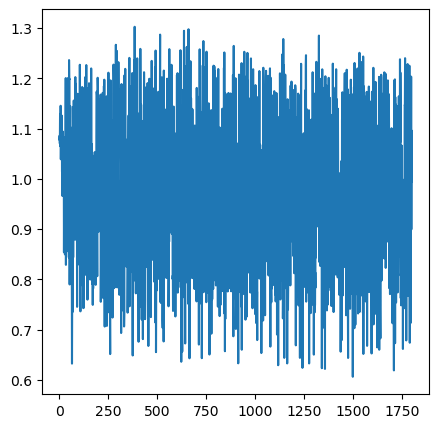

In [222]:
plt.figure(figsize=((5, 5)))
plt.plot([i for i in range(len(l))], l)
plt.show()
display()

In [ ]:
f = open('test.txt', 'w')
for i in l:
    f.write(str(i))
    f.write('\n')